# TODO
- Setup some validation method (Maybe hold out one year, or some small geographic region, or both?)
- Expand the model a bit
    - State fixed effects maybe?
    - Maybe add some features
        - More Census data
        - Distance from coastline
        - Wind speed?

In [1]:
import os

os.environ['DC_STATEHOOD'] = '1'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from us import states

from COS513 import load_all_years_of_noaa_storm_data
from COS513 import load_census_data
from COS513 import load_county_zone_mapping
from COS513 import decode_damage_property

In [167]:
a = pd.read_csv('/Users/aaronspaulding/Documents/PycharmProjects/COS-513-Group-Project/data/SVI_Tract_Data/SVI_2020_US.csv')

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,1,Alabama,AL,1001,Autauga,1001020100,"Census Tract 201, Autauga County, Alabama",3.793570,1941,390,...,2.1,2.7,0.0,1.8,0.0,1.8,6.6,5.1,0.0,1.8
1,1,Alabama,AL,1001,Autauga,1001020200,"Census Tract 202, Autauga County, Alabama",1.282174,1757,310,...,0.0,2.0,0.0,2.0,0.0,2.0,2.6,3.0,0.8,1.1
2,1,Alabama,AL,1001,Autauga,1001020300,"Census Tract 203, Autauga County, Alabama",2.065364,3694,570,...,1.2,1.1,0.0,0.9,0.0,0.9,1.8,2.3,0.0,0.9
3,1,Alabama,AL,1001,Autauga,1001020400,"Census Tract 204, Autauga County, Alabama",2.464984,3539,500,...,0.5,0.6,0.3,0.5,0.0,1.0,2.9,2.8,0.0,1.0
4,1,Alabama,AL,1001,Autauga,1001020501,"Census Tract 205.01, Autauga County, Alabama",2.395243,4306,662,...,1.9,2.0,0.0,0.8,0.0,0.8,0.3,0.6,0.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84117,56,Wyoming,WY,56043,Washakie,56043000200,"Census Tract 2, Washakie County, Wyoming",2231.951436,3124,198,...,0.0,1.1,0.1,0.1,0.0,1.1,1.6,1.8,0.0,1.1
84118,56,Wyoming,WY,56043,Washakie,56043000301,"Census Tract 3.01, Washakie County, Wyoming",0.769579,2231,273,...,0.0,1.6,0.1,0.3,0.0,1.6,5.6,3.8,1.4,1.5
84119,56,Wyoming,WY,56043,Washakie,56043000302,"Census Tract 3.02, Washakie County, Wyoming",5.957251,2578,314,...,0.0,1.3,0.9,1.2,0.0,1.3,2.9,3.5,0.0,1.3
84120,56,Wyoming,WY,56045,Weston,56045951100,"Census Tract 9511, Weston County, Wyoming",2355.222335,3276,280,...,2.0,2.8,0.1,0.1,0.0,1.1,6.1,4.1,0.0,1.1


# Data

    - NOAA Damage Data
    - Census Data

In [3]:
noaa_data = load_all_years_of_noaa_storm_data()
census_data = load_census_data()
county_zone_mapping = load_county_zone_mapping()

Loading NOAA storm data:   0%|          | 0/75 [00:00<?, ?it/s]

In [4]:
# only keep CONUS
idx = noaa_data['STATE_FIPS'] <= 56.5
noaa_data = noaa_data[idx].reset_index(drop=True)
noaa_data = noaa_data[noaa_data['CZ_TYPE'] != 'M'].reset_index(drop=True) # Marine regions

# format FIPS codes
noaa_data['STATE_FIPS'] = noaa_data['STATE_FIPS'].astype(int).astype(str).str.zfill(2)
noaa_data['CZ_FIPS'] = noaa_data['CZ_FIPS'].astype(int).astype(str).str.zfill(3)
fips_to_abbreviation_map = {s.fips: s.abbr for s in states.STATES}
noaa_data['STATE_ABBREVIATION'] = noaa_data['STATE_FIPS'].map(fips_to_abbreviation_map)
noaa_data['STATE_ZONE'] = noaa_data['STATE_ABBREVIATION'] + noaa_data['CZ_FIPS']


county_zone_mapping_trimmed = county_zone_mapping[['STATE_ZONE', 'FIPS', 'LAT', 'LON']].copy()
noaa_data = noaa_data.merge(
    county_zone_mapping_trimmed,
    on='STATE_ZONE',
    how='left'
)

# Now format the COUNTY_FIPS column
noaa_data['COUNTY_FIPS'] = np.nan
noaa_data['COUNTY_FIPS'] = noaa_data['COUNTY_FIPS'].astype(str)
noaa_data.loc[noaa_data['CZ_TYPE'] == 'C', 'COUNTY_FIPS'] = noaa_data.loc[noaa_data['CZ_TYPE'] == 'C', 'CZ_FIPS']
noaa_data.loc[noaa_data['CZ_TYPE'] == 'Z', 'COUNTY_FIPS'] = noaa_data.loc[noaa_data['CZ_TYPE'] == 'Z', 'FIPS'].str[2:]
noaa_data['STATE_COUNTY_FIPS'] = noaa_data['STATE_FIPS'] + noaa_data['COUNTY_FIPS']

# Format Damage Columns
noaa_data['DAMAGE_PROPERTY'] = noaa_data['DAMAGE_PROPERTY'].apply(decode_damage_property)
noaa_data['DAMAGE_CROPS'] = noaa_data['DAMAGE_CROPS'].apply(decode_damage_property)

In [5]:
# only keep hurricane events
hurricane_event_names = ['Hurricane', 'Tropical Depression', 'Hurricane (Typhoon)', 'Tropical Storm']
noaa_data = noaa_data[noaa_data['EVENT_TYPE'].isin(hurricane_event_names)].reset_index(drop=True)

# drop hurricane events that caused 0 or very low total damage anywhere in the US (likely just an ocean event, check this)
storms_to_drop = ['200208', '200705', '200706', '200708', '200710', '200711','201209', '201706', '201805',
 '202006', '202106', '202206', '202207', '202411']
idx = noaa_data['BEGIN_YEARMONTH'].astype(str).isin(storms_to_drop)

noaa_data = noaa_data[~noaa_data['BEGIN_YEARMONTH'].astype(str).isin(storms_to_drop)].reset_index(drop=True)

In [6]:
census_data['state'] = census_data['state'].astype(int).astype(str).str.zfill(2)
census_data['county'] = census_data['county'].astype(int).astype(str).str.zfill(3)
census_data['tract'] = census_data['tract'].astype(int).astype(str).str.zfill(6)

census_data['STATE_COUNTY_FIPS'] = census_data['state'] + census_data['county']
census_data['GEOID'] = census_data['state'] + census_data['county'] + census_data['tract']

census_data.loc[census_data['B19013_001E'] < -1., 'B19013_001E'] = np.nan

In [7]:
damages = noaa_data[['STATE_COUNTY_FIPS', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'BEGIN_YEARMONTH', 'LAT', 'LON']].copy()
damages = damages.dropna(subset=['STATE_COUNTY_FIPS']).reset_index(drop=True)

In [8]:
tract_data = census_data.merge(
    damages,
    on='STATE_COUNTY_FIPS',
    how='inner'
)

tract_data['LAT'] = tract_data['LAT'].astype(np.float64)
tract_data['LON'] = tract_data['LON'].astype(np.float64)

In [9]:
tract_data = tract_data[tract_data['BEGIN_YEARMONTH'] > 200000].reset_index(drop=True)

states_to_drop = []
number_of_data_points_ = []
for state in tract_data['state'].unique():
    idx = tract_data['state'] == state
    number_of_data_points = tract_data[idx].shape[0]

    if number_of_data_points < 1_000:
        # print(number_of_data_points)
        states_to_drop.append(state)
    number_of_data_points_.append(number_of_data_points)



tract_data = tract_data[~tract_data['state'].isin(states_to_drop)].reset_index(drop=True)


# Model

In [10]:
import torch

DEVICE = torch.device('cpu')
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('MPS is available')

DTYPE = torch.float32


import pyro
import pyro.distributions as dist
import torch
import pyro.infer
import pyro.optim
import numpy as np
import pandas as pd

from torch.distributions import constraints
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import scatter_add

MPS is available


In [11]:
income_bins = [
    'B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E', 'B19001_006E',
    'B19001_007E', 'B19001_008E', 'B19001_009E', 'B19001_010E', 'B19001_011E',
    'B19001_012E', 'B19001_013E', 'B19001_014E', 'B19001_015E', 'B19001_016E', 'B19001_017E'
]

In [12]:
tract_data['income_less_than_25_000'] = tract_data[['B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E']].sum(axis=1)
tract_data['income_between_25_000_and_50_000'] = tract_data[['B19001_006E', 'B19001_007E', 'B19001_008E', 'B19001_009E', 'B19001_010E']].sum(axis=1)
tract_data['income_between_50_000_and_75_000'] = tract_data[['B19001_011E', 'B19001_012E']].sum(axis=1)
tract_data['income_between_75_000_and_100_000'] = tract_data[['B19001_013E', 'B19001_013E']].sum(axis=1)
tract_data['income_greater_than_100_00'] = tract_data[['B19001_014E', 'B19001_015E', 'B19001_016E', 'B19001_017E']].sum(axis=1)


tract_data['income_less_than_25_000_share'] = tract_data['income_less_than_25_000'] / tract_data['B19001_001E']
tract_data['income_between_25_000_and_50_000_share'] = tract_data['income_between_25_000_and_50_000'] / tract_data['B19001_001E']
tract_data['income_between_50_000_and_75_000_share'] = tract_data['income_between_50_000_and_75_000'] / tract_data['B19001_001E']
tract_data['income_between_75_000_and_100_000_share'] = tract_data['income_between_75_000_and_100_000'] / tract_data['B19001_001E']
tract_data['income_greater_than_100_00_share'] = tract_data['income_greater_than_100_00'] / tract_data['B19001_001E']


In [131]:
# Clean data
df_clean = tract_data[
    ['B01001_001E', 'B19001_001E', 'B19013_001E', 'DAMAGE_PROPERTY', 'county', 'state', 'BEGIN_YEARMONTH',
     'income_less_than_25_000_share', 'income_between_25_000_and_50_000_share',
     'income_between_50_000_and_75_000_share', 'income_between_75_000_and_100_000_share',
     'income_greater_than_100_00_share'

     ]].dropna()

# Inputs (log-scale demographics, raw damages)
pop = torch.tensor(np.log1p(df_clean['B01001_001E'].values), dtype=DTYPE, device=DEVICE)
households = torch.tensor(np.log1p(df_clean['B19001_001E'].values), dtype=DTYPE, device=DEVICE)
income = torch.tensor(np.log1p(df_clean['B19013_001E'].values), dtype=DTYPE, device=DEVICE)
# damage_property = torch.tensor(df_clean['DAMAGE_PROPERTY'].values, dtype=DTYPE, device=DEVICE)

income_less_than_25_000_share = torch.tensor(np.log1p(df_clean['income_less_than_25_000_share'].values), dtype=DTYPE,
                                             device=DEVICE)
income_between_25_000_and_50_000_share = torch.tensor(
    np.log1p(df_clean['income_between_25_000_and_50_000_share'].values), dtype=DTYPE, device=DEVICE)
income_between_50_000_and_75_000_share = torch.tensor(
    np.log1p(df_clean['income_between_50_000_and_75_000_share'].values), dtype=DTYPE, device=DEVICE)
income_between_75_000_and_100_000_share = torch.tensor(
    np.log1p(df_clean['income_between_75_000_and_100_000_share'].values), dtype=DTYPE, device=DEVICE)
income_greater_than_100_00_share = torch.tensor(np.log1p(df_clean['income_greater_than_100_00_share'].values),
                                                dtype=DTYPE, device=DEVICE)

# Define storm_county key
df_clean['storm_county'] = df_clean['BEGIN_YEARMONTH'].astype(str) + '_' + df_clean['state'] + df_clean['county']
storm_county_idx, storm_county_keys = pd.factorize(df_clean['storm_county'])
storm_county_idx = torch.tensor(storm_county_idx, dtype=torch.long, device=DEVICE)

# County-level target (sum of tract damages per county/storm)
aggregated_damages_storm_county = df_clean.groupby('storm_county')['DAMAGE_PROPERTY'].sum().reset_index()
y_county = torch.tensor(aggregated_damages_storm_county['DAMAGE_PROPERTY'].values, dtype=DTYPE, device=DEVICE)

# Sizes
num_tracts = len(df_clean)
num_counties = len(storm_county_keys)


class Model:
    def model(self, pop, households,
              income_less_than_25_000_share,
              income_between_25_000_and_50_000_share,
              income_between_50_000_and_75_000_share,
              income_between_75_000_and_100_000_share,
              income_greater_than_100_00_share,
              storm_county_idx, y_county):
        epsilon = torch.tensor(1e-3, device=DEVICE)

        beta_0 = pyro.sample('beta_0', dist.Normal(torch.tensor(-0.6, device=DEVICE), torch.tensor(10., device=DEVICE)))
        beta_pop = pyro.sample('beta_pop',
                               dist.Normal(torch.tensor(1.0, device=DEVICE), torch.tensor(0.5, device=DEVICE)))
        beta_households = pyro.sample('beta_households',
                                      dist.Normal(torch.tensor(0.66, device=DEVICE), torch.tensor(0.5, device=DEVICE)))

        beta_income_prior = dist.Normal(torch.tensor(0., device=DEVICE), torch.tensor(1., device=DEVICE))
        beta_income_less_than_25_000_share = pyro.sample('beta_income_less_than_25_000_share', beta_income_prior)
        beta_income_between_25_000_and_50_000_share = pyro.sample('beta_income_between_25_000_and_50_000_share',
                                                                  beta_income_prior)
        beta_income_between_50_000_and_75_000_share = pyro.sample('beta_income_between_50_000_and_75_000_share',
                                                                  beta_income_prior)
        beta_income_between_75_000_and_100_000_share = pyro.sample('beta_income_between_75_000_and_100_000_share',
                                                                   beta_income_prior)
        beta_income_greater_than_100_00_share = pyro.sample('beta_income_greater_than_100_00_share', beta_income_prior)

        sigma_tract = pyro.sample('sigma_tract', dist.HalfNormal(torch.tensor(0.5, device=DEVICE)))
        sigma_county = pyro.sample('sigma_county', dist.HalfNormal(torch.tensor(11., device=DEVICE)))

        mean_income_betas = (beta_income_less_than_25_000_share +
                             beta_income_between_25_000_and_50_000_share +
                             beta_income_between_50_000_and_75_000_share +
                             beta_income_between_75_000_and_100_000_share +
                             beta_income_greater_than_100_00_share
                             ) / torch.tensor(5., device=DEVICE)

        with pyro.plate('tracts', num_tracts):
            mu_tract = (
                beta_0 +
                beta_pop * pop +
                beta_households * households +
                (beta_income_less_than_25_000_share - mean_income_betas) * income_less_than_25_000_share +
                (beta_income_between_25_000_and_50_000_share - mean_income_betas) * income_between_25_000_and_50_000_share +
                (beta_income_between_50_000_and_75_000_share - mean_income_betas) * income_between_50_000_and_75_000_share +
                (beta_income_between_75_000_and_100_000_share - mean_income_betas) * income_between_75_000_and_100_000_share +
                (beta_income_greater_than_100_00_share - mean_income_betas) * income_greater_than_100_00_share
            )

            damage_tract = pyro.sample('damage_tract', dist.LogNormal(mu_tract, sigma_tract))

        damage_county = torch.zeros(num_counties, dtype=DTYPE, device=DEVICE).scatter_add(
            dim=0, index=storm_county_idx, src=damage_tract
        )

        damage_county = torch.clamp(damage_county, min=epsilon)
        bias_correction_slope = pyro.sample(
            'bias_correction_slope',
            dist.LogNormal(torch.tensor(2.0, device=DEVICE), torch.tensor(1.0, device=DEVICE))
        )

        damage_county_corrected = damage_county * bias_correction_slope


        mean = damage_county_corrected
        std = sigma_county
        concentration = (mean / std) ** 2
        rate = mean / (std ** 2)
        with pyro.plate('counties', num_counties):
            pyro.sample(
                'obs_county',
                dist.Gamma(concentration, rate),
                obs=y_county + epsilon
            )


In [132]:
# Instantiate and train
pyro.clear_param_store()
model = Model()
guide = AutoDelta(model.model)
svi = SVI(model.model, guide, Adam({'lr': 0.1}), loss=Trace_ELBO())

num_steps = 500
losses = []
for step in range(num_steps):
    # loss = svi.step(pop, income, households, storm_county_idx, y_county)
    loss = svi.step(pop, households,
                    income_less_than_25_000_share,
                    income_between_25_000_and_50_000_share,
                    income_between_50_000_and_75_000_share,
                    income_between_75_000_and_100_000_share,
                    income_greater_than_100_00_share,
                    storm_county_idx, y_county)
    losses.append(loss)
    if step % 500 == 0:
        print(f'Step {step}: Loss = {loss:.2f}')


Step 0: Loss = 1012156597182718592.00


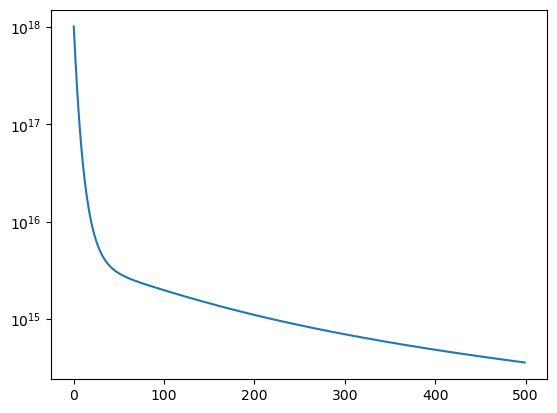

In [133]:
plt.plot(losses)
plt.yscale('symlog')

In [136]:
params = guide()
with torch.no_grad():
    # Extract fixed effect parameters
    beta_0 = params['beta_0']
    beta_pop = params['beta_pop']
    beta_households = params['beta_households']

    beta_income_lt_25k = params['beta_income_less_than_25_000_share']
    beta_income_25k_50k = params['beta_income_between_25_000_and_50_000_share']
    beta_income_50k_75k = params['beta_income_between_50_000_and_75_000_share']
    beta_income_75k_100k = params['beta_income_between_75_000_and_100_000_share']
    beta_income_gt_100k = params['beta_income_greater_than_100_00_share']

    # Centered mean income effect
    mean_income_beta = (
        beta_income_lt_25k +
        beta_income_25k_50k +
        beta_income_50k_75k +
        beta_income_75k_100k +
        beta_income_gt_100k
    ) / 5.0

    # Predicted log-mean damages at tract level
    mu_tract_pred = (
        beta_0 +
        beta_pop * pop +
        beta_households * households +
        (beta_income_lt_25k - mean_income_beta) * income_less_than_25_000_share +
        (beta_income_25k_50k - mean_income_beta) * income_between_25_000_and_50_000_share +
        (beta_income_50k_75k - mean_income_beta) * income_between_50_000_and_75_000_share +
        (beta_income_75k_100k - mean_income_beta) * income_between_75_000_and_100_000_share +
        (beta_income_gt_100k - mean_income_beta) * income_greater_than_100_00_share
    )

    # Expected value of LogNormal distribution
    sigma_tract = params['sigma_tract']
    damage_tract_pred = torch.exp(mu_tract_pred + 0.5 * sigma_tract**2)

    # Aggregate tract-level predicted damages to counties
    damage_county_pred = torch.zeros(num_counties, dtype=DTYPE, device=DEVICE).scatter_add(
        dim=0, index=storm_county_idx, src=damage_tract_pred
    )

    # Apply learned scalar bias correction
    bias_correction_slope = params['bias_correction_slope']
    damage_county_corrected = damage_county_pred * bias_correction_slope


In [165]:
beta_0, beta_pop, beta_households

(tensor(-1.4049, device='mps:0', grad_fn=<ExpandBackward0>),
 tensor(0.8563, device='mps:0', grad_fn=<ExpandBackward0>),
 tensor(0.3155, device='mps:0', grad_fn=<ExpandBackward0>))

(tensor(-1.4049, device='mps:0', grad_fn=<ExpandBackward0>),
 tensor(0.8563, device='mps:0', grad_fn=<ExpandBackward0>),
 tensor(0.3155, device='mps:0', grad_fn=<ExpandBackward0>))

In [161]:
params = guide()
with torch.no_grad():
    beta_income_less_than_25_000_share = params['beta_income_less_than_25_000_share']
    beta_income_between_25_000_and_50_000_share = params['beta_income_between_25_000_and_50_000_share']
    beta_income_between_50_000_and_75_000_share = params['beta_income_between_50_000_and_75_000_share']
    beta_income_between_75_000_and_100_000_share = params['beta_income_between_75_000_and_100_000_share']
    beta_income_greater_than_100_00_share = params['beta_income_greater_than_100_00_share']

beta_income_groups = [beta_income_less_than_25_000_share, beta_income_between_25_000_and_50_000_share, beta_income_between_50_000_and_75_000_share, beta_income_between_75_000_and_100_000_share, beta_income_greater_than_100_00_share]
beta_income_groups = np.array([i.detach().cpu().numpy() for i in beta_income_groups])
beta_income_groups = beta_income_groups - np.mean(beta_income_groups)
beta_income_groups

array([ 0.04336686,  0.12087613, -0.36132342,  0.34186473, -0.14478423],
      dtype=float32)

In [116]:
beta_income_groups = [beta_income_less_than_25_000_share, beta_income_between_25_000_and_50_000_share, beta_income_between_50_000_and_75_000_share, beta_income_between_75_000_and_100_000_share, beta_income_greater_than_100_00_share]
beta_income_groups = np.array([i.detach().cpu().numpy() for i in beta_income_groups])
beta_income_groups = beta_income_groups - np.mean(beta_income_groups)
beta_income_groups

array([ 0.17475373, -0.04387057,  0.10925123, -0.17964338, -0.06049095],
      dtype=float32)

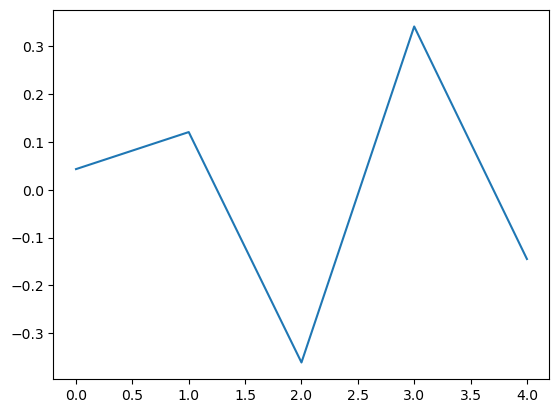

In [162]:
plt.plot(beta_income_groups)

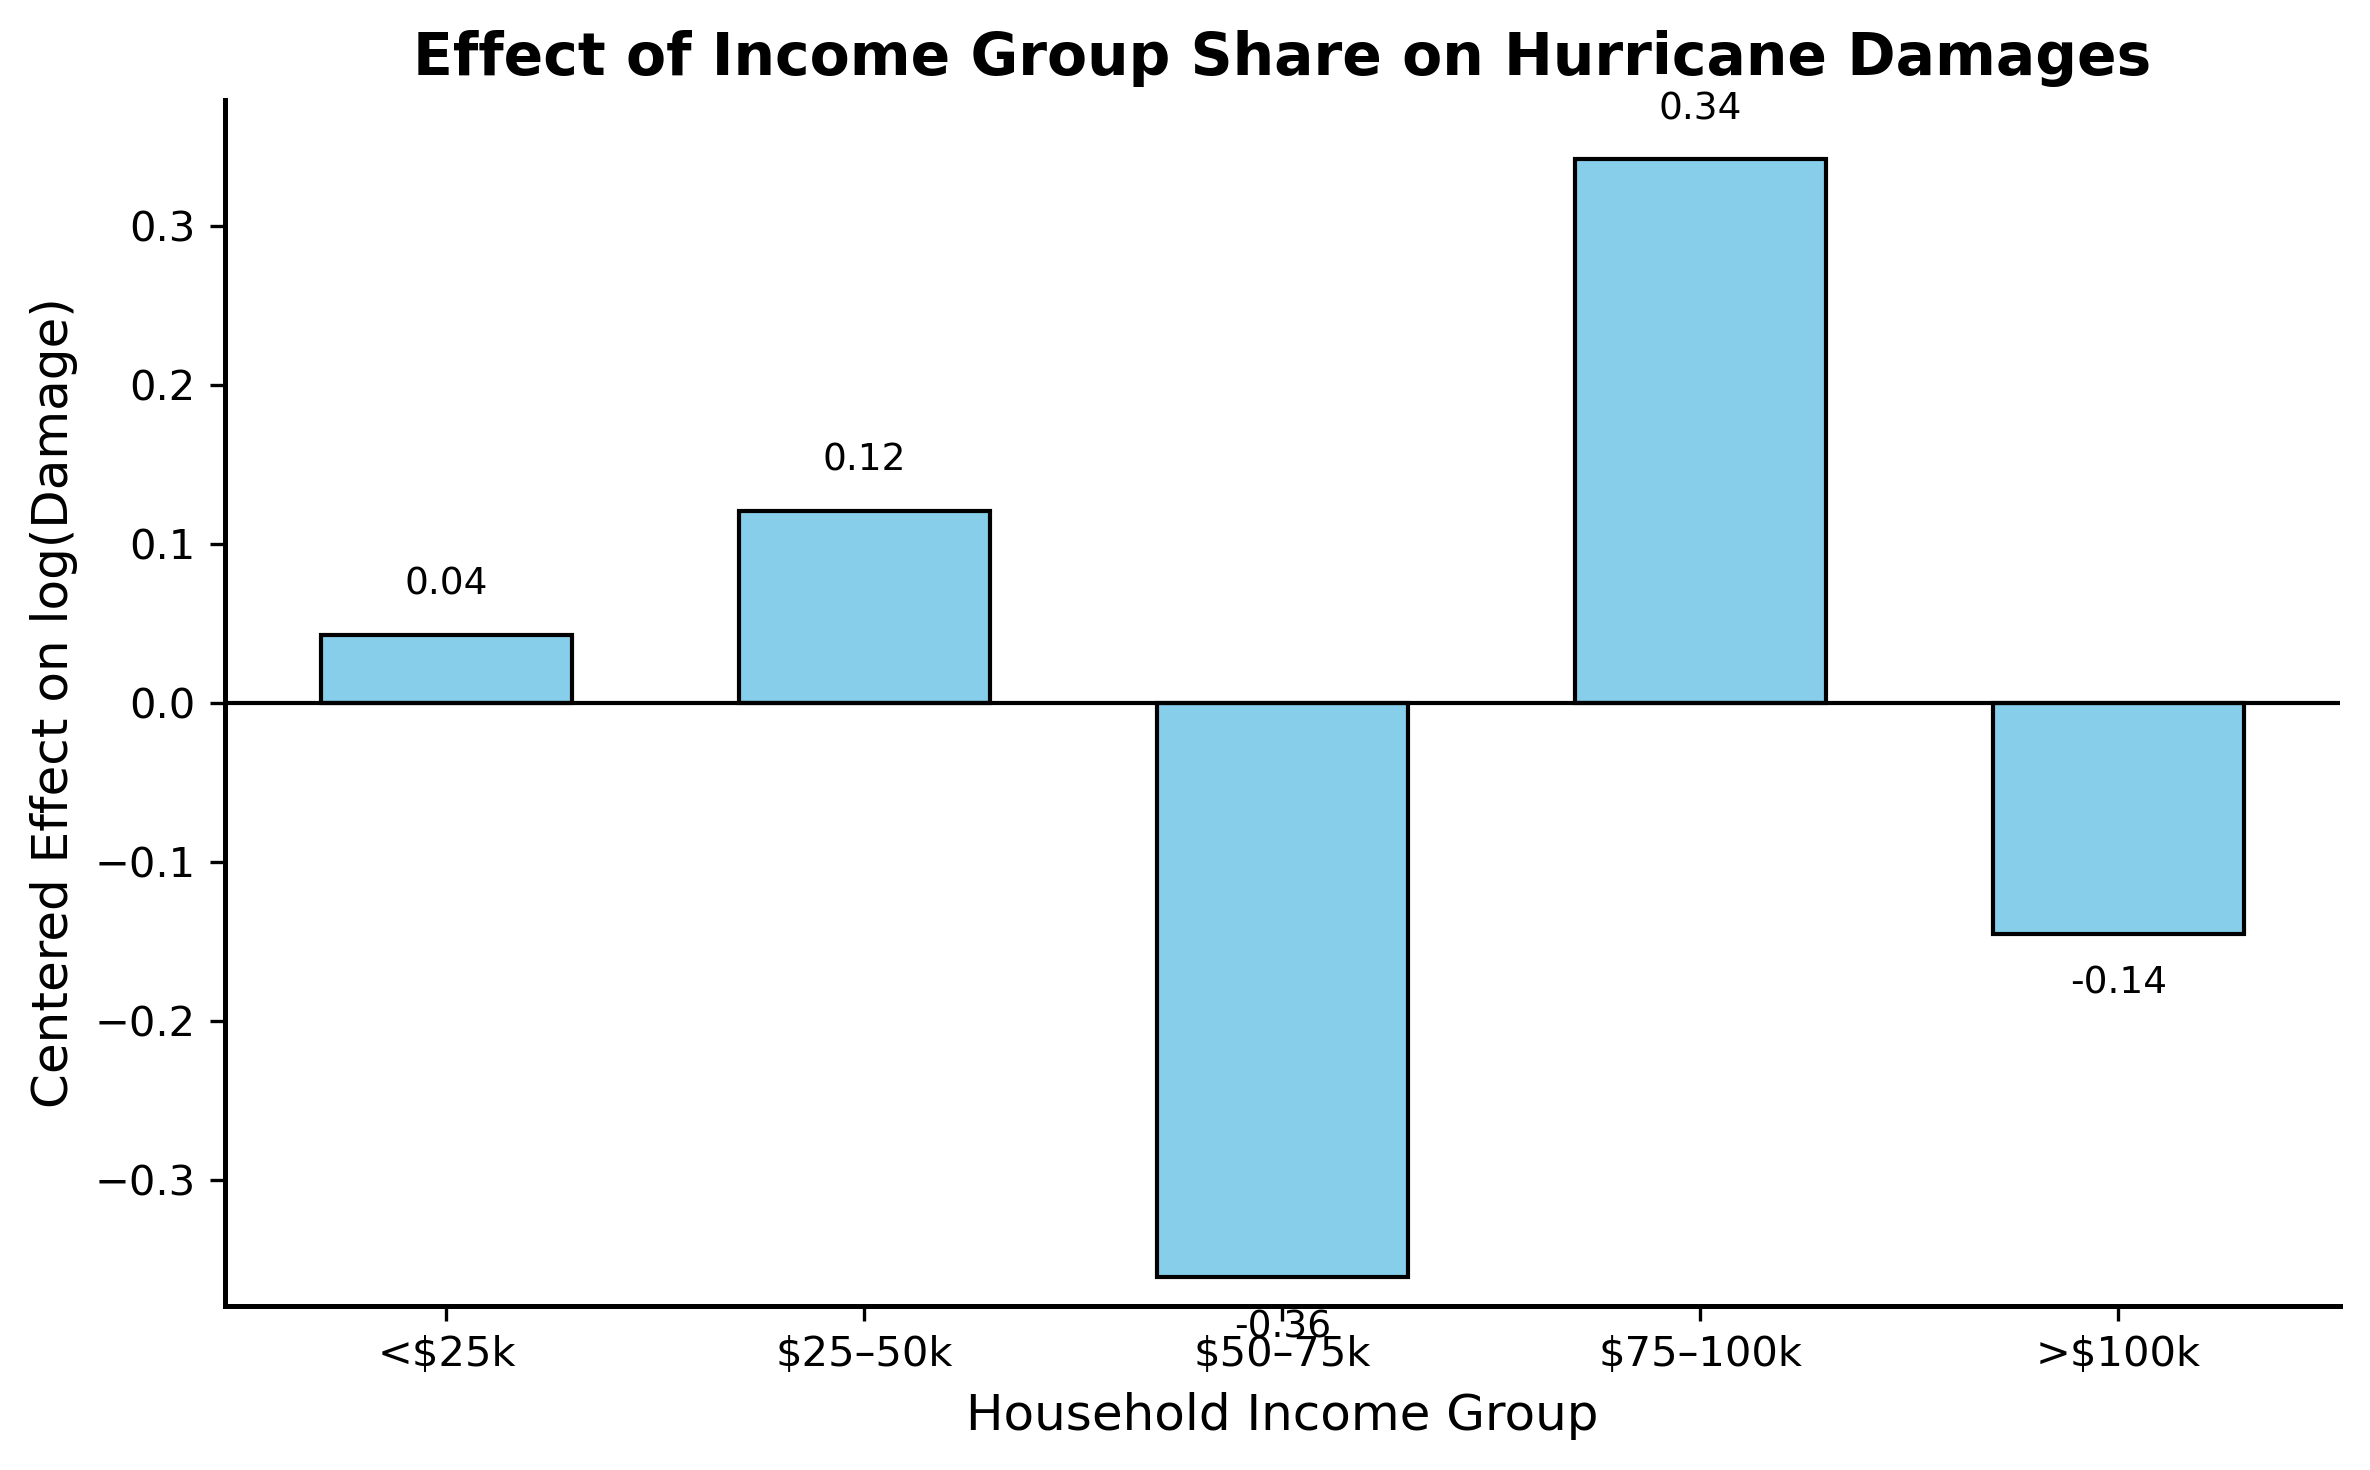

In [163]:
import matplotlib.pyplot as plt
import numpy as np

# These are your grouped beta values (already centered)
values = np.array([0.043, 0.121, -0.361, 0.342, -0.145])

income_labels = [
    '<$25k', '$25–50k', '$50–75k', '$75–100k', '>$100k'
]

# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

bars = ax.bar(range(len(values)), values, width=0.6, color='skyblue', edgecolor='black')

ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(range(len(income_labels)))
ax.set_xticklabels(income_labels, rotation=0, ha='center', fontsize=11)
ax.set_ylabel('Centered Effect on log(Damage)', fontsize=12)
ax.set_xlabel('Household Income Group', fontsize=12)
ax.set_title('Effect of Income Group Share on Hurricane Damages', fontsize=14, weight='bold')

# Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.tick_params(axis='both', which='major', labelsize=10)

# Y-axis limits based on data
y_margin = 0.05
y_max = max(values.max(), abs(values.min())) * (1 + y_margin)
ax.set_ylim(-y_max, y_max)

# Annotate bars
for i, v in enumerate(values):
    ax.text(i, v + (0.02 if v >= 0 else -0.02), f'{v:.2f}', ha='center', va='bottom' if v >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

In [138]:
# predicted_damages = damage_county_pred.cpu().numpy()
predicted_damages = damage_county_corrected.cpu().numpy()

In [143]:
aggregated_damages_storm_county['storm'] = aggregated_damages_storm_county['storm_county'].str[0:6]
aggregated_damages_storm_county['predictions'] = predicted_damages

storm_damages = aggregated_damages_storm_county.groupby(['storm']).agg(
    {
        'DAMAGE_PROPERTY': 'sum',
        'predictions': 'sum',
    }
).reset_index()


In [158]:
# bias correction
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(np.log1p(storm_damages['predictions'].values.reshape(-1, 1)),
          np.log1p(storm_damages['DAMAGE_PROPERTY']))


log_corrected = model.predict(np.log1p(storm_damages['predictions'].values.reshape(-1, 1)))
corrected = np.expm1(log_corrected)

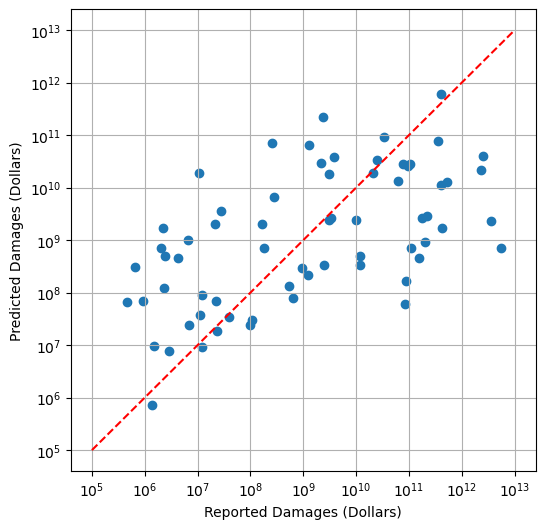

In [152]:
plt.figure(figsize=(6, 6))
plt.scatter(storm_damages['DAMAGE_PROPERTY'], corrected)
# plt.scatter(storm_damages['DAMAGE_PROPERTY'], storm_damages['predictions'])
plt.plot([1e5, 1e13], [1e5, 1e13], 'r--')
# plt.xlabel('True log1p(DAMAGE_PROPERTY)')
plt.xlabel('Reported Damages (Dollars)')
plt.ylabel('Predicted Damages (Dollars)')
# plt.xlim([1e3, 1e13])
# plt.ylim([1e3, 1e13])
plt.yscale('symlog')
plt.xscale('symlog')
plt.grid(True)
plt.show()


In [153]:
print(r2_score(
    np.log10(storm_damages['DAMAGE_PROPERTY']),
    np.log10(corrected))
)

0.3239862450516987


In [154]:
from sklearn.metrics import root_mean_squared_error

print(root_mean_squared_error(
    np.log10(storm_damages['DAMAGE_PROPERTY']),
    np.log10(corrected))
)

1.66147733914696
